In [ ]:
#!pip install transformers accelerate bitsandbytes datasets matplotlib --quiet

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [18]:
import math
import random
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from copy import deepcopy
from torch.utils.data import DataLoader, Dataset, TensorDataset
from datasets import load_dataset
import re
from transformers.models.llama.modeling_llama import LlamaAttention

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "TinyLlama/TinyLlama_v1.1"

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map={"": device},
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


print("Model loaded on:", device)

`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on: cuda


In [9]:
#fix seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [12]:
print("Loading MMLU and GSM8K subsets...")

mmlu = load_dataset("cais/mmlu", "all", split="test")
# We'll use the "test" split from a subset of subjects
mmlu_subjects = [
    "abstract_algebra",
    "high_school_physics",
    "college_chemistry",
    "high_school_computer_science"
]

mmlu_examples = []
#print(mmlu)
for subj in mmlu_subjects:
    ds = load_dataset("cais/mmlu", subj, split="test")
    #print(ds)

    num_ex = max(100, len(ds["question"]))
    for idx in range(num_ex):
        # Normalize choices/options
        choices = ds["choices"][idx] 
        answer_idx = ds["answer"][idx]  

        # Only keep four-choice questions
        if len(choices) != 4:
            continue
    
        mmlu_examples.append({
            "question": ds["question"][idx],
            "choices": choices,
            "answer_idx": int(answer_idx),
        })

print("MMLU subset size:", len(mmlu_examples))
gsm8k = load_dataset("openai/gsm8k", "main", split="test")
k = max(1, min(int(0.1 * len(gsm8k)), 300))
idxs = random.sample(range(len(gsm8k)), k)
gsm8k_examples = [gsm8k[i] for i in idxs]
print("GSM8K subset size:", len(gsm8k_examples))
ppl_texts_mmlu = [ex["question"] for ex in mmlu_examples]
print("Perplexity texts mmlu:", len(ppl_texts_mmlu))
ppl_texts_gsm8k = [ex["question"] for ex in gsm8k_examples]
print("Perplexity texts gsm8k:", len(ppl_texts_gsm8k))

Loading MMLU and GSM8K subsets...
MMLU subset size: 451
GSM8K subset size: 131
Perplexity texts mmlu: 451
Perplexity texts gsm8k: 131


In [15]:
#evaluation Utilities
def compute_loglikelihood(model, tokenizer, prompt, continuation, max_length=512):
    model.eval()
    with torch.no_grad():
        full = prompt + continuation
        enc = tokenizer(full, return_tensors="pt", truncation=True, max_length=max_length ).to(device)

        input_ids = enc["input_ids"]
        prompt_enc = tokenizer( prompt, return_tensors="pt", truncation=True, max_length=max_length).to(device)
        prompt_len = prompt_enc["input_ids"].size(1)
        labels = input_ids.clone()
        labels[:, :prompt_len] = -100

        out = model(input_ids=input_ids, labels=labels)
        nll = out.loss.item() * (labels != -100).sum().item()
        return -nll


def evaluate_mmlu(model, tokenizer, mmlu_examples, max_length=512):
    correct = 0
    total = len(mmlu_examples)
    for ex in mmlu_examples:
        q = ex["question"]
        choices = ex["choices"]
        gold = ex["answer_idx"]
        prompt = (
            "Question: " + q + "\n" +
            "A. " + choices[0] + "\n" +
            "B. " + choices[1] + "\n" +
            "C. " + choices[2] + "\n" +
            "D. " + choices[3] + "\n" +
            "Answer:"
        )
        labels = [" A", " B", " C", " D"]
        scores = []
        for cand in labels:
            scores.append(compute_loglikelihood(model, tokenizer, prompt, cand, max_length))
        pred = max(range(4), key=lambda i: scores[i])
        if pred == gold:
            correct += 1
    return correct / total


number_pattern = re.compile(r"(-?\d+(\.\d+)?)")

def extract_last_number(text):
    matches = number_pattern.findall(text)
    if not matches:
        return None
    return matches[-1][0]


def generate_answer(model, tokenizer, question, max_new_tokens=64):
    prompt = "Question: " + question + "\nAnswer:"
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        out_ids = model.generate(
            **enc,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.0,
            pad_token_id=tokenizer.eos_token_id
        )
    text = tokenizer.decode(out_ids[0], skip_special_tokens=True)
    return text


def evaluate_gsm8k(model, tokenizer, gsm8k_examples, max_new_tokens=64):
    correct = 0
    total = len(gsm8k_examples)
    for ex in gsm8k_examples:
        q = ex["question"]
        gt_answer_full = ex["answer"]
        gt_num = extract_last_number(gt_answer_full)

        pred_full = generate_answer(model, tokenizer, q, max_new_tokens=max_new_tokens)
        pred_num = extract_last_number(pred_full)

        if gt_num is not None and pred_num is not None and gt_num == pred_num:
            correct += 1
    return correct / total


def compute_perplexity(model, tokenizer, texts, max_length=256, batch_size=4):
    model.eval()
    total_nll = 0.0
    total_tokens = 0
    dl = DataLoader(texts, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for batch in dl:
            enc = tokenizer(
                batch,
                return_tensors="pt",
                truncation=True,
                max_length=max_length,
                padding=True,
            ).to(device)

            input_ids = enc["input_ids"]
            attention_mask = enc["attention_mask"]
            labels = input_ids.clone()
            labels[attention_mask == 0] = -100

            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss
            n_tokens = attention_mask.sum().item()
            total_nll += loss.item() * n_tokens
            total_tokens += n_tokens

    avg_nll = total_nll / total_tokens
    ppl = math.exp(avg_nll)
    return ppl


def eval_fn(model, tokenizer):
    print("  Evaluating MMLU...")
    acc_mmlu = evaluate_mmlu(model, tokenizer, mmlu_examples)
    print("  Evaluating GSM8K...")
    acc_gsm8k = evaluate_gsm8k(model, tokenizer, gsm8k_examples)
    print("  Evaluating perplexity...")
    #ppl_mmlu = compute_perplexity(model, tokenizer, ppl_texts_mmlu)
    ppl_gsm8k = compute_perplexity(model, tokenizer, ppl_texts_gsm8k)
    print(f"  MMLU={acc_mmlu:.3f}, GSM8K={acc_gsm8k:.3f}, PPL GSM8K={ppl_gsm8k:.1f}")
    return acc_mmlu, acc_gsm8k, ppl_gsm8k


In [17]:
#Baseline Evaluation
print("Baseline Qwen3-0.6B Evaluation")
baseline_acc_mmlu, baseline_acc_gsm8k, baseline_ppl_gsm8k = eval_fn(base_model, tokenizer)
baseline_results = {
    "model_type": ["baseline"],
    "acc_mmlu": [baseline_acc_mmlu],
    "acc_gsm8k": [baseline_acc_gsm8k],
    "ppl_gsm8k": [baseline_ppl_gsm8k],
}


Baseline Qwen3-0.6B Evaluation
  Evaluating MMLU...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.242, GSM8K=0.031, PPL GSM8K=17.2


NameError: name 'pd' is not defined

In [19]:
df_baseline = pd.DataFrame(baseline_results)
df_baseline.to_csv("baseline_results.csv", index=False)
print(df_baseline)

  model_type  acc_mmlu  acc_gsm8k  ppl_gsm8k
0   baseline  0.241685   0.030534  17.205842


In [20]:
#build a LM training dataset for Router
print("Loading MMLU and GSM8K subsets...")

#mmlu = load_dataset("cais/mmlu", "all", split="train")
# We'll use the "test" split from a subset of subjects
mmlu_subjects = [
    "abstract_algebra",
    "high_school_physics",
    "college_chemistry",
    "high_school_computer_science"
]

mmlu_examples_train = []
#print(mmlu)
for subj in mmlu_subjects:
    ds = load_dataset("cais/mmlu", subj, split="validation")
    #print(ds)

    num_ex = min(100, len(ds["question"]))
    for idx in range(num_ex):
        # Normalize choices/options
        choices = ds["choices"][idx] 
        answer_idx = ds["answer"][idx]  

        # Only keep four-choice questions
        if len(choices) != 4:
            continue
    
        mmlu_examples.append({
            "question": ds["question"][idx],
            "choices": choices,
            "answer_idx": int(answer_idx),
        })

print("MMLU subset size:", len(mmlu_examples))
gsm8k = load_dataset("openai/gsm8k", "main", split="train")

gsm8k_examples_train = [gsm8k[i] for i in range(len(gsm8k))]
print("GSM8K subset size:", len(gsm8k_examples))
"""
ppl_texts_mmlu = [ex["question"] for ex in mmlu_examples[:45]]
print("Perplexity texts mmlu:", len(ppl_texts_mmlu))
ppl_texts_gsm8k = [ex["question"] for ex in gsm8k_examples[:45]]
print("Perplexity texts gsm8k:", len(ppl_texts_gsm8k))
"""

Loading MMLU and GSM8K subsets...
MMLU subset size: 496
GSM8K subset size: 131


'\nppl_texts_mmlu = [ex["question"] for ex in mmlu_examples[:45]]\nprint("Perplexity texts mmlu:", len(ppl_texts_mmlu))\nppl_texts_gsm8k = [ex["question"] for ex in gsm8k_examples[:45]]\nprint("Perplexity texts gsm8k:", len(ppl_texts_gsm8k))\n'

In [30]:
class LMDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        enc = self.tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=self.max_length,
            padding="max_length"
        )
        input_ids = enc["input_ids"].squeeze(0)
        attention_mask = enc["attention_mask"].squeeze(0)
        labels = input_ids.clone()
        labels[attention_mask == 0] = -100
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

train_texts = []
for ex in gsm8k_examples_train:
    train_texts.append(ex["question"])
    if "answer" in ex and isinstance(ex["answer"], str):
        train_texts.append(ex["answer"])
for ex in mmlu_examples_train:
    train_texts.append(ex["question"])
random.shuffle(train_texts)
train_texts = train_texts[:1000]

train_ds_lm = LMDataset(train_texts, tokenizer, max_length=128)
train_loader_lm = DataLoader(train_ds_lm, batch_size=4, shuffle=True)


In [22]:
class MoHRouter(nn.Module):
    """
    Mixture-of-Heads router:
    """
    def __init__(self, hidden_size, num_heads, shared_ratio=0.25, top_k=4):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_heads = num_heads

        self.shared = max(1, int(num_heads * shared_ratio))
        self.routed = max(1, num_heads - self.shared)
        self.top_k = min(top_k, self.routed)

        self.W_s = nn.Linear(hidden_size, self.shared)
        self.W_r = nn.Linear(hidden_size, self.routed)
        self.W_h = nn.Linear(hidden_size, 2)

        # small init to avoid huge logits
        nn.init.xavier_uniform_(self.W_s.weight, gain=0.1)
        nn.init.xavier_uniform_(self.W_r.weight, gain=0.1)
        nn.init.xavier_uniform_(self.W_h.weight, gain=0.1)

    def forward(self, hidden_states):
        """"    
        Input:
           hidden_states
        Output:
           Output: per-head probabilities 
        """
        #use fp32 to avoid overflow and NaN
        x = hidden_states.float() 
        scale = math.sqrt(self.hidden_size)

        logits_h = self.W_h(x) / scale    
        alpha = torch.softmax(logits_h, dim=-1)

        s_scores = self.W_s(x) / scale
        r_scores = self.W_r(x) / scale

        s_soft = torch.softmax(s_scores, dim=-1)
        r_soft = torch.softmax(r_scores, dim=-1)

        # Top-k on routed heads
        topk_idx = torch.topk(r_scores, k=self.top_k, dim=-1).indices
        mask = torch.zeros_like(r_scores).scatter_(-1, topk_idx, 1.0)
        r_masked = r_soft * mask

        s_final = alpha[..., 0:1] * s_soft
        r_final = alpha[..., 1:2] * r_masked

        probs = torch.cat([s_final, r_final], dim=-1)
        probs = torch.clamp(probs, 1e-6, 1.0 - 1e-6)
        return probs


class LlamaAttentionWithRouter(nn.Module):
    """
    Wraps a LlamaAttention module with a MoH router.
    """
    def __init__(self, attn_module, config, layer_idx, shared_ratio=0.25, top_k=4):
        super().__init__()
        assert isinstance(attn_module, LlamaAttention)
        self.attn = attn_module
        self.hidden_size = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.hidden_size // self.num_heads
        self.layer_idx = layer_idx

        self.router = MoHRouter(
            hidden_size=self.hidden_size,
            num_heads=self.num_heads,
            shared_ratio=shared_ratio,
            top_k=top_k,
        )

        # Keep router in fp32 but on the same device as attention weights
        ref_param = next(attn_module.parameters())
        self.router = self.router.to(device=ref_param.device, dtype=torch.float32)

        self.last_router_probs = None  

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        position_ids=None,
        past_key_value=None,
        output_attentions=False,
        use_cache=False,
        **kwargs,
    ):
        # call to original LlamaAttention
        out = self.attn(
            hidden_states=hidden_states,
            attention_mask=attention_mask,
            position_ids=position_ids,
            past_key_value=past_key_value,
            output_attentions=output_attentions,
            use_cache=use_cache,
            **kwargs,
        )

        if output_attentions:
            attn_output, attn_weights, present_key_value = out
        else:
            attn_output, present_key_value = out
            attn_weights = None

        router_in = hidden_states.float()
        router_probs = self.router(router_in)
        self.last_router_probs = router_probs.to(hidden_states.dtype)

        if output_attentions:
            return attn_output, attn_weights, present_key_value
        else:
            return attn_output, present_key_value

def convert_llama_to_router(model, shared_ratio=0.25, top_k=4):
    """
    Replaces each LlamaAttention block with LlamaAttentionWithRouter.
    """
    config = model.config
    for i, layer in enumerate(model.model.layers):
        attn = layer.self_attn
        wrapped = LlamaAttentionWithRouter(
            attn_module=attn,
            config=config,
            layer_idx=i,
            shared_ratio=shared_ratio,
            top_k=top_k,
        )
        layer.self_attn = wrapped
    print("Converted LLaMA attention to LlamaAttentionWithRouter in all layers.")
    return model

In [23]:
def moh_load_balance_loss(model, eps=1e-6):
    """
    Compute load-balancing loss from router_probs in each layer.
    For each layer:
      - Take last_router_probs
      - Average over batch+sequence 
      - Encourage it to be close to uniform (high entropy, low variance).
    """
    losses = []
    for layer in model.model.layers:
        attn = layer.self_attn
        if not isinstance(attn, LlamaAttentionWithRouter):
            continue
        probs = attn.last_router_probs  # [B,S,H] or None
        if probs is None:
            continue
        # average over batch+sequence
        p = probs.mean(dim=(0, 1))  
        p = p / (p.sum() + eps)
        # entropy term (maximize entropy == minimize -entropy)
        entropy = -(p * (p + eps).log()).sum()
        # variance term (want low variance)
        var = p.var()
        # Combine (neg entropy + var)
        loss_layer = -entropy + var
        losses.append(loss_layer)

    if not losses:
        return torch.tensor(0.0, device=next(model.parameters()).device)

    return torch.stack(losses).mean()


In [27]:
def collect_router_head_importance(model, texts, max_length=128, batch_size=4, device=None):
    """
    Use router_probs to compute per-head importance:
      - For each batch, get last_router_probs per layer.
      - Average over batch+sequence per head.
    Returns: tensor [num_layers, num_heads]
    """
    if device is None:
        device = next(model.parameters()).device

    model.eval()
    n_layers = model.config.num_hidden_layers
    n_heads = model.config.num_attention_heads

    head_importance = torch.zeros(n_layers, n_heads, device=device)
    count = 0

    dl = DataLoader(texts, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in dl:
            enc = tokenizer( list(batch), return_tensors="pt", truncation=True, max_length=max_length, padding=True,).to(device)

            outputs = model(**enc, labels=enc["input_ids"])
            # routers have updated last_router_probs
            for i, layer in enumerate(model.model.layers):
                attn = layer.self_attn
                if not isinstance(attn, LlamaAttentionWithRouter):
                    continue
                probs = attn.last_router_probs  # [B,S,H]
                if probs is None:
                    continue
                p = probs.mean(dim=(0, 1))  # [H]
                head_importance[i] += p
            count += 1

    head_importance /= max(count, 1)
    return head_importance

def prune_heads_by_router_importance(model, head_importance, sparsity=0.2):
    """
    Zero out the least important heads globally according to router-based importance.
    """
    hi = head_importance.detach().cpu()
    n_layers, n_heads = hi.shape
    total_heads = n_layers * n_heads

    num_to_prune = int(sparsity * total_heads)
    if num_to_prune <= 0:
        print("Nothing to prune.")
        return []

    flat_scores = hi.view(-1)
    prune_idx = torch.topk(flat_scores, k=num_to_prune, largest=False).indices

    pairs = [(int(idx // n_heads), int(idx % n_heads)) for idx in prune_idx]

    hidden_size = model.config.hidden_size
    num_heads = model.config.num_attention_heads
    head_dim = hidden_size // num_heads

    print(f"Pruning {num_to_prune}/{total_heads} heads "
          f"({100.0 * sparsity:.1f}% sparsity)")

    with torch.no_grad():
        for (layer_idx, head_idx) in pairs:
            layer = model.model.layers[layer_idx]
            attn = layer.self_attn.attn if isinstance(layer.self_attn, LlamaAttentionWithRouter) else layer.self_attn
            q_proj = attn.q_proj
            k_proj = attn.k_proj
            v_proj = attn.v_proj
            o_proj = attn.o_proj
            start = head_idx * head_dim
            end = (head_idx + 1) * head_dim
            q_proj.weight[start:end, :] = 0
            if q_proj.bias is not None:
                q_proj.bias[start:end] = 0
            k_proj.weight[start:end, :] = 0
            if k_proj.bias is not None:
                k_proj.bias[start:end] = 0
            v_proj.weight[start:end, :] = 0
            if v_proj.bias is not None:
                v_proj.bias[start:end] = 0
            o_proj.weight[:, start:end] = 0
    return pairs

In [24]:
router_model = deepcopy(base_model)
router_model = convert_llama_to_router(router_model, shared_ratio=0.25, top_k=4)
router_model.to(device)

Converted LLaMA attention to LlamaAttentionWithRouter in all layers.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 2048)
    (layers): ModuleList(
      (0-21): 22 x LlamaDecoderLayer(
        (self_attn): LlamaAttentionWithRouter(
          (attn): LlamaAttention(
            (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
            (k_proj): Linear(in_features=2048, out_features=256, bias=False)
            (v_proj): Linear(in_features=2048, out_features=256, bias=False)
            (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          )
          (router): MoHRouter(
            (W_s): Linear(in_features=2048, out_features=8, bias=True)
            (W_r): Linear(in_features=2048, out_features=24, bias=True)
            (W_h): Linear(in_features=2048, out_features=2, bias=True)
          )
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=2048, out_features=5632, bias=False)
          (up_proj): Linear(in_features=2048, out_features=5632, bias=False)
 

In [26]:
#freeze base model and unfreeze router params only
for p in router_model.parameters():
    p.requires_grad = False
    
router_params = []
for layer in router_model.model.layers:
    attn = layer.self_attn
    if isinstance(attn, LlamaAttentionWithRouter):
        for p in attn.router.parameters():
            p.requires_grad = True
            router_params.append(p)

optimizer = torch.optim.AdamW(router_params, lr=5e-5)
max_grad_norm = 1.0
lambda_lb = 1.0  # weight for load-balance loss

print(f"Trainable router params: {sum(p.numel() for p in router_params):,}")

Trainable router params: 1,532,652


In [ ]:
for p in p_values:
    print(f"Pruning target {p*100:.1f}%")
    torch.cuda.empty_cache()
    m = deepcopy(base_model_cpu)
    #'''
    #model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16,device_map="auto")
    #m = model
    #'''
    pruner = MagnitudePruner(p)
    actual = pruner.apply(m)
    m = m.to(device)
    acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k = eval_fn(m, tokenizer)
    results_mag.append([actual, acc_mmlu, acc_gsm8k, ppl_mmlu, ppl_gsm8k])
    #free gpu memory to avoid oom error
    del m
    #del pruner
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

df_mag = pd.DataFrame(results_mag, columns=["p_actual", "acc_mmlu", "acc_gsm8k", "ppl_mmlu", "ppl_gsm8k"])
df_mag.to_csv("magnitude_pruning_results.csv", index=False)
print(df_mag.head())


In [39]:
epochs = 15
router_model.train()
loss_list = []
for epoch in range(epochs): 
    total_loss = 0
    total_sample = 0
    for step, batch in enumerate(train_loader_lm):

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = router_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        #outputs = router_model(**batch.to(device))
        lm_loss = outputs.loss.float()
        lb_loss = moh_load_balance_loss(router_model).float()

        #train only routers (LM frozen) using LB loss
        loss = lambda_lb * lb_loss

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(router_params, max_grad_norm)
        optimizer.step()
        total_loss += loss.item()
        total_sample += batch["input_ids"].shape[0]
    total_loss /=total_sample
    loss_list.append(total_loss)
    print( f"Epoch {epoch}, Loss={total_loss:.4f}")

Epoch 0, Loss=-0.7007
Epoch 1, Loss=-0.7011
Epoch 2, Loss=-0.7025
Epoch 3, Loss=-0.7023
Epoch 4, Loss=-0.7032
Epoch 5, Loss=-0.7025
Epoch 6, Loss=-0.7035
Epoch 7, Loss=-0.7043
Epoch 8, Loss=-0.7044
Epoch 9, Loss=-0.7047
Epoch 10, Loss=-0.7041
Epoch 11, Loss=-0.7046
Epoch 12, Loss=-0.7051
Epoch 13, Loss=-0.7048
Epoch 14, Loss=-0.7047


Router head importance shape: (22, 32)


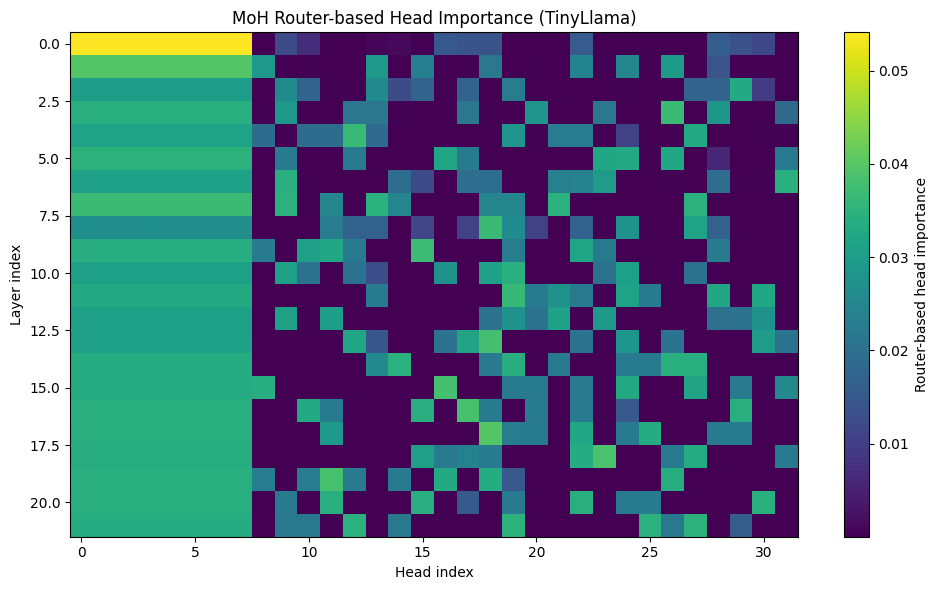

In [40]:
print("Collecting router-based head importance...")
router_head_importance = collect_router_head_importance(
    router_model,
    ppl_texts_gsm8k,
    max_length=128,
    batch_size=4,
    device=device,
)
router_head_importance_np = router_head_importance.detach().cpu().numpy()
print("Router head importance shape:", router_head_importance_np.shape)


plt.figure(figsize=(10, 6))
plt.imshow(router_head_importance_np, aspect="auto")
plt.colorbar(label="Router-based head importance")
plt.xlabel("Head index")
plt.ylabel("Layer index")
plt.title("MoH Router-based Head Importance (TinyLlama)")
plt.tight_layout()
plt.show()

In [44]:
# Evaluate router-guided head pruning on a fresh copy of base model
sparsity = 0.2
pruned_model = deepcopy(base_model).to(device)
pruned_heads = prune_heads_by_router_importance(
    pruned_model,
    router_head_importance,
    sparsity=sparsity,
)

print("Total pruned heads:", len(pruned_heads))
print("Re-evaluating perplexity after router-guided head pruning...")
print(f"Baseline PPL: {baseline_ppl_gsm8k:.2f}")

Pruning 140/704 heads (20.0% sparsity)
Total pruned heads: 140
Re-evaluating perplexity after router-guided head pruning...
Baseline PPL: 17.21


In [45]:
#Baseline Evaluation
print("Pruned model evaluation Evaluation")
pruned20_acc_mmlu, pruned20_acc_gsm8k, pruned20_ppl_gsm8k = eval_fn(pruned_model, tokenizer)
pruned20_results = {
    "model_type": ["baseline"],
    "acc_mmlu": [pruned20_acc_mmlu],
    "acc_gsm8k": [pruned20_acc_gsm8k],
    "ppl_gsm8k": [pruned20_ppl_gsm8k],
}


Pruned model evaluation Evaluation
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.228, GSM8K=0.031, PPL GSM8K=29.5


In [46]:
print(df_baseline)

  model_type  acc_mmlu  acc_gsm8k  ppl_gsm8k
0   baseline  0.241685   0.030534  17.205842


In [47]:
# Evaluate router-guided head pruning on a fresh copy of base model
sparsity = 0.4
pruned_model = deepcopy(base_model).to(device)
pruned_heads = prune_heads_by_router_importance(
    pruned_model,
    router_head_importance,
    sparsity=sparsity,
)

print("Total pruned heads:", len(pruned_heads))
print("Re-evaluating perplexity after router-guided head pruning...")
print(f"Baseline PPL: {baseline_ppl_gsm8k:.2f}")
#Baseline Evaluation
print("Pruned model evaluation Evaluation")
pruned40_acc_mmlu, pruned40_acc_gsm8k, pruned40_ppl_gsm8k = eval_fn(pruned_model, tokenizer)
pruned40_results = {
    "model_type": ["baseline"],
    "acc_mmlu": [pruned40_acc_mmlu],
    "acc_gsm8k": [pruned40_acc_gsm8k],
    "ppl_gsm8k": [pruned40_ppl_gsm8k],
}

Pruning 281/704 heads (40.0% sparsity)
Total pruned heads: 281
Re-evaluating perplexity after router-guided head pruning...
Baseline PPL: 29.51
Pruned model evaluation Evaluation
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.208, GSM8K=0.031, PPL GSM8K=75.2


In [48]:
#evaluate router-guided head pruning on a fresh copy of base model
sparsity = 0.3
pruned_model = deepcopy(base_model).to(device)
pruned_heads = prune_heads_by_router_importance(
    pruned_model,
    router_head_importance,
    sparsity=sparsity,
)

print("Total pruned heads:", len(pruned_heads))
print("Re-evaluating perplexity after router-guided head pruning...")
print(f"Baseline PPL: {baseline_ppl_gsm8k:.2f}")
#Baseline Evaluation
print("Pruned model evaluation Evaluation")
pruned30_acc_mmlu, pruned30_acc_gsm8k, pruned30_ppl_gsm8k = eval_fn(pruned_model, tokenizer)
pruned30_results = {
    "model_type": ["baseline"],
    "acc_mmlu": [pruned30_acc_mmlu],
    "acc_gsm8k": [pruned30_acc_gsm8k],
    "ppl_gsm8k": [pruned30_ppl_gsm8k],
}

Pruning 211/704 heads (30.0% sparsity)
Total pruned heads: 211
Re-evaluating perplexity after router-guided head pruning...
Baseline PPL: 75.19
Pruned model evaluation Evaluation
  Evaluating MMLU...
  Evaluating GSM8K...
  Evaluating perplexity...
  MMLU=0.220, GSM8K=0.031, PPL GSM8K=39.1
